# Classification of Characters in Super Smash Bros. Melee
-----

- [Executive Summary](#Executive-Summary)
- [What is Transfer Learning?](#What-is-Transfer-Learning?)
- [Transfer Learning Code](#Transfer-Learning-Code)
 - [Review the Data](#Review-the-Data)
 - [Extract Features](#Extract-Features)
 - [Train the Network](#Train-the-Network)
 - [Test the Network](#Test-the-Network)
- [Discussion](#Discussion)
- [Appendix - Data Generation](#Appendix---Data-Generation)
 - [Install Dolphin](#Install-Dolphin)
 - [Make Images and Masks](#Make-Images-and-Masks)
- [Appendix - Data Preprocessing](#Appendix---Data-Preprocessing)
 - [Set up AWS](#Set-up-AWS)
 - [Split Data into Train/Test/Valid](#Split-Data-into-Train/Test/Valid)

Note: **I am a data scientist in the Bay Area!  Feel free to contact me with questions, concerns, offers for work ;)**

- [trevor.m.murphy@gmail.com](mailto:trevor.m.murphy@gmail.com)
- [LinkedIn](https://www.linkedin.com/in/trevor-murphy-49ba1421)
- [GitHub](https://github.com/tmurph)

# Executive Summary

This notebook contains the code and resources to recognize the most common player avatars (hereafter, characters) used by professional players of the competitive fighting game Super Smash Bros. Melee.

A neural network is given images captured from scripted game play and trained via transfer learning from VGG16.  In tests the network achieves ~96% classification accuracy after ~15 training epochs.  Here is a representative confusion matrix obtained after one such test:

![](jupyter_images/confusion_matrix.png)

# What is Transfer Learning?

The following contains merely the briefest description of transfer learning.  [Many](https://machinelearningmastery.com/transfer-learning-for-deep-learning/) [more](http://ruder.io/transfer-learning/) [thorough](https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/) [explanations](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/torrey.handbook09.pdf) exist and can be found with a simple Google search.  I assume the reader is already familiar with convolutional neural networks (CNN).

With this project I aimed to train a neural network to classify custom-generated data with greater than 90% classification accuracy.  One might construct a neural network from scratch for this purpose, but such an approach would also raise significant challenges and force difficult tradeoffs between depth and cost.  The desired accuracy would require a sufficiently deep network, while the cost to train such a network would increase rapidly with depth.

A common alternative to from-scratch training is transfer learning, where pre-trained, state-of-the-art image classification models are repurposed to suit a data set that may differ significantly from the original training data.  When this approach works it can significantly reduce the amount of training (and therefore cost) required to achieve the desired classification accuracy.

The first step of a transfer learning solution is selecting a model.  The [ImageNet Large Scale Visual Recognition Challenge](http://image-net.org/challenges/LSVRC/) attracts the attention of brilliant researchers and the resources of universities and large internet companies.  As such, winning models make excellent starting points for transfer learning.  Not all models are equally easy to repurpose for any given data set, however.  
  
Following [this blog post from the Keras developers](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) I selected VGG16 for this project.  My custom-generated images differ in size from the ImageNet training data, but VGG16’s simple convolutional architecture makes it uniquely capable of adapting to this difference.  
  
The last step in transfer learning is called “fine-tuning” and involves retraining or replacing the final layers of the model to increase the accuracy of predictions on the new data set.  The Keras library makes this particularly easy to do.

# Transfer Learning Code

## Review the Data

First, let me show some of the images used to train the CNN.  Over 100,000 images were used, so this is just a random sample.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 12]

import numpy as np

In [ ]:
import os
import re

DATA_DIR = "data/keras"

all_images = []
for root, dirs, files in os.walk(os.path.join(DATA_DIR, 'train', 'images')):
    all_images.extend(files)

img_re = re.compile('(?:[^/]*/)*'
                    '(?P<character>[^_]*)_'
                    '(?P<color>[^_]*)_'
                    '(?P<stage>[^_]*)_'
                    '(?P<orientation>[^_]*)_'
                    'bg_on_'
                    '(?P<img_number>[0-9]{3})'
                    '.jpg')

def get_image(character, color, stage, orientation, img_number):
    image = os.path.join(DATA_DIR, 'train', 'images', character,
                         '{character}_{color}_{stage}_{orientation}_bg_on_{img_number}.jpg'.format(character=character,
                                                                                                   color=color,
                                                                                                   stage=stage,
                                                                                                   orientation=orientation,
                                                                                                   img_number=img_number))

    rgb_image = plt.imread(image)

    return rgb_image

def get_image_by_name(name):
    image_groups = re.search(img_re, name)
    return get_image(**image_groups.groupdict())

IMAGE_ROW_SIZE, IMAGE_COLUMN_SIZE, IMAGE_DEPTH = get_image_by_name(all_images[0]).shape

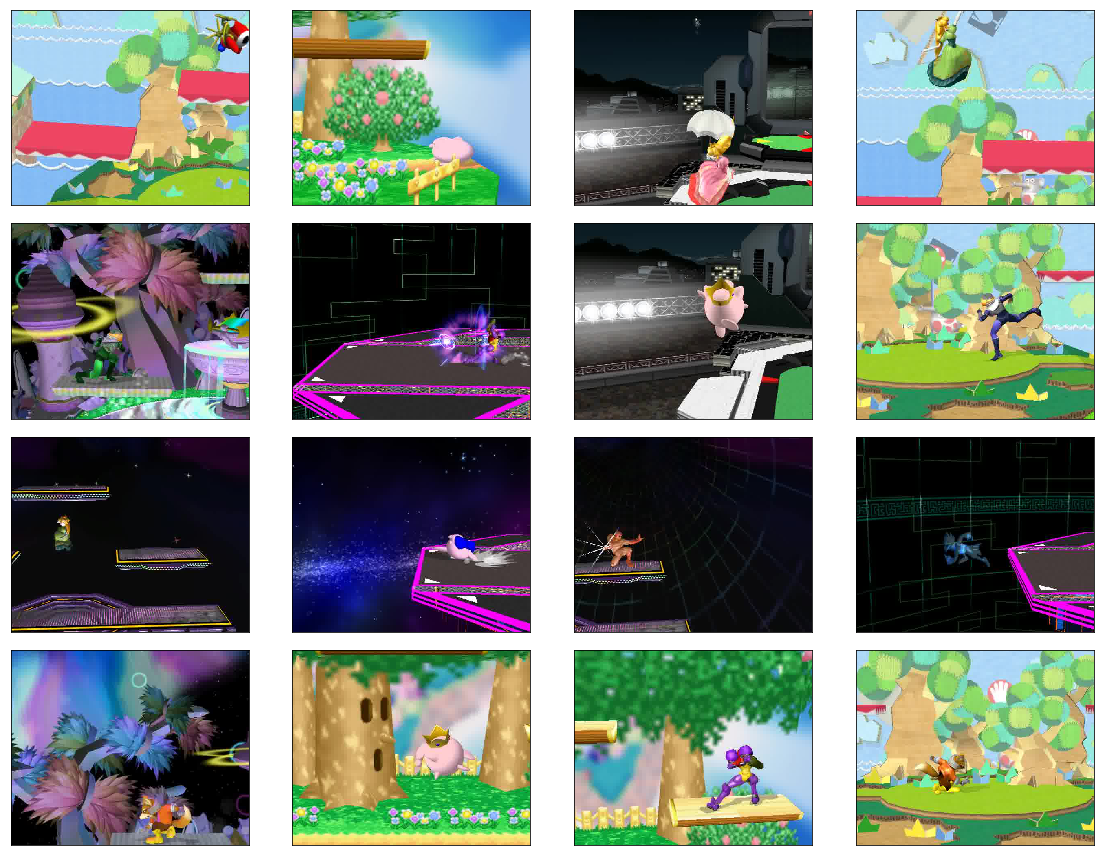

In [ ]:
import random

NUM_ROWS = 4
NUM_COLS = 4

fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS, sharex=True, sharey=True, squeeze=False)

for i, image_name in enumerate(random.sample(all_images, NUM_ROWS * NUM_COLS)):
    ax = axarr[divmod(i, NUM_COLS)]
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.imshow(get_image_by_name(image_name))

fig.tight_layout()

These images were all captured from scripted gameplay.  The [Data Generation](#Data-Generation) section includes technical details on the capturing process.  
  
Compare these images against the images used in the ImageNet competition to train VGG16.  E.g. [these images from the persian cat category](http://imagenet.stanford.edu/synset?wnid=n02123394).

Without additional metadata about the captured images, such as character bounding boxes or pose annotation points, I cannot easily compute rich statistics about the images.  However, visual inspection suggests the following differences to me:  
  
- **Size within frame**
  - Characters in captured images rarely fill more than 10% of the frame
  - Objects in ImageNet images often fill 25% or more of the frame
- **Variation of pose / orientation**
  - Characters in captured images, coming from a video game, contort into an extremely wide variety of poses
  - Objects in ImageNet images are constrained by real biology
- **Composition within frame**
  - Captured images frequently include visual effects like smoke and explosions, which can occlude parts of the characters
  - In the video game characters frequently fall off the side of the frame, resulting in capture images that cut off part of the character
  - ImageNet images are comparatively well composed, placing the object in the front of the frame and fairly close to the center  
  
Despite these differences, VGG16 is able to extract useful features that lead to accurate image classification.  This is the power of award-winning neural networks and transfer learning.

## Extract Features

Running image data through VGG16 is computationally expensive, so I will do it just once and cache the results for the later fine-tuning work.  These intermediate results I am caching are typically thought of as “important features” that have been “extracted” from the image data.  The extracted features are realized as a very large floating point array.  
  
This caching technique trades off increased memory requirements against decreased computational time.  Fortunately, memory is cheap relative to GPU compute, so this trade off makes sense for my problem.

The following code blocks set up the VGG model.  
  
I want to take advantage of all the available GPUs, which I accomplish with the function `keras.utils.multi_gpu_model`.  This function accepts a template model (typically compiled for a CPU-only architecture) and creates an identical model compiled for a multi-GPU architecture.

In [ ]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.utils import multi_gpu_model
from keras.models import clone_model
from GPUtil import getGPUs

try:
    NUM_GPU = len(getGPUs())
except:
    NUM_GPU = 0

def gpuify_model_maybe(model):
    result = None
    if NUM_GPU >= 2:
        result = multi_gpu_model(model, gpus=NUM_GPU)
    elif NUM_GPU == 1:
        with tf.device("/gpu:0"):
            result = clone_model(model)
    else:
        result = model
    return result

In [ ]:
with tf.device("/cpu:0"):
    template_vgg_model = VGG16(include_top=False, weights="imagenet", input_shape=(IMAGE_ROW_SIZE, IMAGE_COLUMN_SIZE, IMAGE_DEPTH))
gpu_vgg_model = gpuify_model_maybe(template_vgg_model)

The following code blocks set up the data flow into the model.  
  
As with most transfer learning work, I must preprocess the images to match key statistical features of the original data set.  The function `keras.applications.imagenet_utils.preprocess_input` does precisely this.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

BATCH_SIZE = 16 * max(NUM_GPU, 1)

def make_generator(folder="train",
                   data_gen_args={"fill_mode": "constant",
                                  "cval": 0,
                                  "width_shift_range": 0.05,
                                  "height_shift_range": 0.05,
                                  "zoom_range": 0.1,
                                  "horizontal_flip": True,
                                  "preprocessing_function": preprocess_input},
                   data_flow_args={"seed": 1,
                                   "batch_size": BATCH_SIZE}):

    image_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        directory=os.path.join(DATA_DIR, folder, "images"),
        target_size=(IMAGE_ROW_SIZE, IMAGE_COLUMN_SIZE),
        color_mode='rgb',
        **data_flow_args)

    return image_generator

Due to the design of the Keras library, I can’t retain the image labels through the image feature extraction code.  To work around this, I iterate over the images twice, in the same deterministic order both times, pulling out features one time and labels the other.

For feature extraction, I use the `model.predict_generator` API, which requires a generator that emits solely arrays of images (as opposed to pairs like `(image_array, label_array)`).  To get this required generator I set the keyword parameter `class_mode=None`.  I also set the keyword parameter `shuffle=False` so that the features are extracted in deterministic order.

In [ ]:
image_generator_train = make_generator("train", data_gen_args={"preprocessing_function": preprocess_input},
                                       data_flow_args={"batch_size": BATCH_SIZE, "class_mode": None, "shuffle": False})

For label extraction, I set the keyword parameter `shuffle=False` again to iterate in the same order as above, but I fall back to the default `class_mode` in order to retain image labels.

In [ ]:
label_generator_train = make_generator("train", data_gen_args={}, data_flow_args={"batch_size": BATCH_SIZE, "shuffle": False})

Keras’ image data generator API will actually generate images indefinitely.  This supports the common use case of continuously running a neural network for an arbitrary number of epochs.  To end the generation early, I first define a few helper functions.

In [ ]:
def count_images(folder="train"):
    image_directory = os.path.join(DATA_DIR, folder, "images")
    data_size = 0

    for char_name in os.listdir(image_directory):
        char_directory = os.path.join(image_directory, char_name)
        data_size += len(os.listdir(char_directory))

    return data_size

def truncate_generator(gen, limit=None):
    if limit is None:
        return

    for i, elt in enumerate(gen):
        if i < limit:
            yield elt
        else:
            break

Now I extract the training image features and labels.  Note that the following code can take a significant amount of time to run.

In [ ]:
image_count_train = count_images("train")
image_count_train_generator_cutoff = image_count_train / BATCH_SIZE + 1

train_labels = []
for _, labels in truncate_generator(label_generator_train, image_count_train_generator_cutoff):
    train_labels.extend(labels)
train_labels = np.array(train_labels[:image_count_train])

train_data = gpu_vgg_model.predict_generator(image_generator_train, steps=image_count_train_generator_cutoff)
train_data = train_data[:image_count_train]

Now I extract the analogous pair of arrays for the validation images.

In [ ]:
image_count_valid = count_images("valid")
image_count_valid_generator_cutoff = image_count_valid / BATCH_SIZE + 1

image_generator_valid = make_generator("valid", data_gen_args={"preprocessing_function": preprocess_input},
                                       data_flow_args={"batch_size": BATCH_SIZE, "class_mode": None, "shuffle": False})
label_generator_valid = make_generator("valid", data_gen_args={}, data_flow_args={"batch_size": BATCH_SIZE, "shuffle": False})

valid_labels = []
for _, labels in truncate_generator(label_generator_valid, image_count_valid_generator_cutoff):
    valid_labels.extend(labels)
valid_labels = np.array(valid_labels[:image_count_valid])

valid_data = gpu_vgg_model.predict_generator(image_generator_valid, steps=image_count_valid_generator_cutoff)
valid_data = valid_data[:image_count_valid]

Now I have training and validation arrays, but they are in non-random order.  Before training the neural network I randomize these arrays, being careful to preserve the pairwise correlation between features and labels.

In [ ]:
train_random_index = np.arange(train_data.shape[0])
np.random.shuffle(train_random_index)
train_data = train_data[train_random_index]
train_labels = train_labels[train_random_index]

valid_random_index = np.arange(valid_data.shape[0])
np.random.shuffle(valid_random_index)
valid_data = valid_data[valid_random_index]
valid_labels = valid_labels[valid_random_index]

## Train the Network

In the following code, I build the model in a CPU environment but compile it for a GPU environment.  Because the class labels are relatively balanced in terms of number of images, I use categorical crossentropy as the loss function and classification accuracy as the headline metric.

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense

LEARNING_RATE = 0.0001
NUM_CHARACTERS = len(os.listdir(os.path.join(DATA_DIR, "train", "images")))

def build_model(input_shape, target_num=NUM_CHARACTERS, hidden_width=128, hidden_depth=1, dropout_rate=0.2):
    with tf.device("/cpu:0"):
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))
        for _ in range(hidden_depth):
            model.add(Dense(hidden_width, activation='relu', kernel_initializer='lecun_uniform'))
            model.add(Dropout(dropout_rate))
        model.add(Dense(target_num, activation='softmax'))

    return model

def compile_model(model, learning_rate=LEARNING_RATE):
    model = gpuify_model_maybe(model)
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

The following callbacks will, first, ensure early stopping in case of a bad model, and, second, improve learning as the model reaches diminishing returns.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

stop_on_val_loss = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

Here’s a quick summary of the model, as a sanity check.

In [ ]:
template_model = build_model(train_data.shape[1:], hidden_width=512, hidden_depth=3, dropout_rate=0.2)
template_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 138240)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               70779392  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
__________

Finally!  Time to train!

In [ ]:
compiled_model = compile_model(template_model)

training_history = compiled_model.fit(train_data, train_labels,
                                      epochs=15,
                                      batch_size=BATCH_SIZE,
                                      validation_data=(valid_data, valid_labels),
                                      callbacks=[stop_on_val_loss, reduce_lr])

Due to a bug in Keras, I cannot directly save the weights and structure of a model compiled for multiple GPUs.  However, the multi-GPU model object shares both structure and weights with the template model object, which can be saved to disk.  
  
The `template_model`, however, is not yet useable for testing / production.  It expects an array of VGG16 features, but testing will instead provide images.  
  
The remedy is to first stack the `template_model` on top of the `template_vgg_model` and then save the stacked result to disk.

In [ ]:
from keras.models import Model
import datetime

output_layer = template_vgg_model.output
for layer in template_model.layers:
    output_layer = layer(output_layer)
full_model = Model(inputs=template_vgg_model.input, outputs=output_layer)
full_model.save(os.path.join(DATA_DIR, datetime.datetime.today().strftime('%Y-%m-%d-%H-%M') + "-model.h5"))

## Test the Network

To compare true classification labels with the predictions the model emits, I’ll iterate twice over the test images: one pass will run the images through the model to produce predicted labels; the other will collect the true labels for the images.

In [ ]:
image_count_test = count_images("test")
image_count_test_generator_cutoff = image_count_test / BATCH_SIZE + 1

image_generator_test = make_generator("test", data_gen_args={"preprocessing_function": preprocess_input},
    data_flow_args={"batch_size": BATCH_SIZE, "class_mode": None, "shuffle": False})
label_generator_test = make_generator("test", data_gen_args={}, data_flow_args={"batch_size": BATCH_SIZE, "shuffle": False})

In [ ]:
true_labels = []
for _, labels in truncate_generator(label_generator_test, image_count_test_generator_cutoff):
    true_labels.extend(labels)
true_labels = np.array(true_labels[:image_count_test])
true_classes = true_labels.argmax(1)

In [ ]:
pred_labels = full_model.predict_generator(image_generator_test, steps=image_count_test_generator_cutoff)
pred_labels = pred_labels[:image_count_test]
pred_classes = pred_labels.argmax(1)

In [ ]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(true_classes, pred_classes)

In [ ]:
import itertools

def plot_confusion_matrix(matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

By default the class labels are encoded as integers, but the actual class names used by the `label_generator` object can be used instead.

In [ ]:
class_names = [c for c, i in sorted(label_generator_test.class_indices.items(), key=lambda pair: pair[1])]

Visualize the model accuracy!

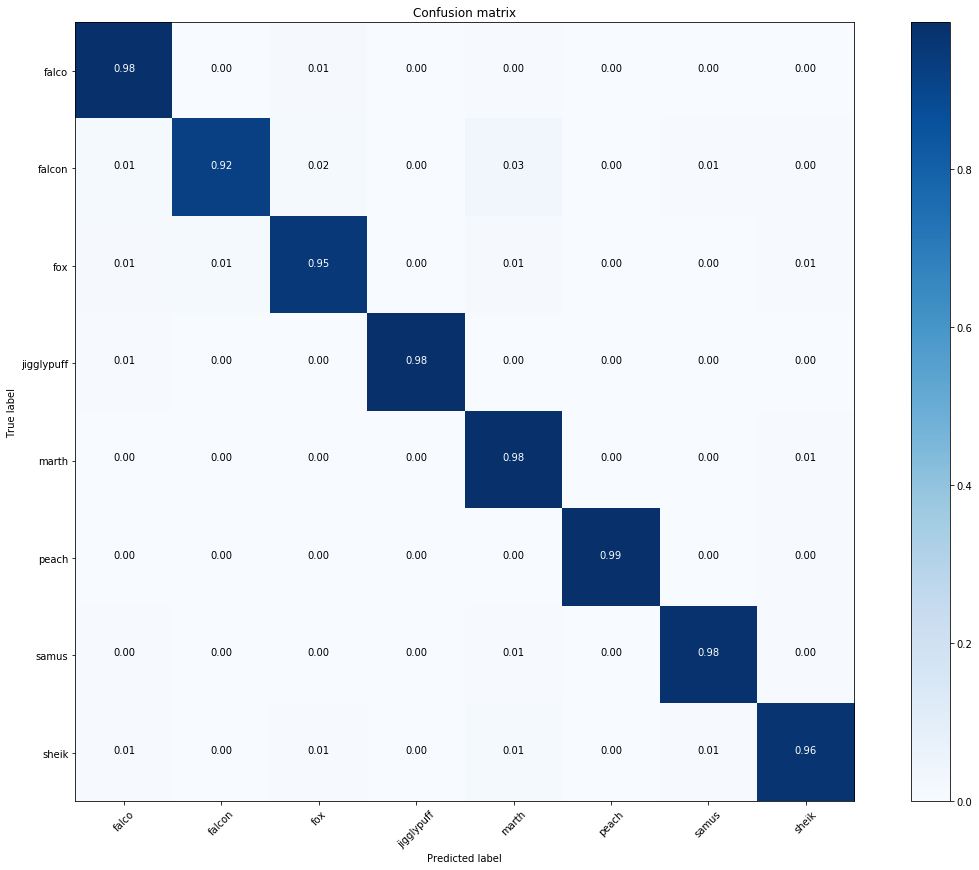

In [ ]:
plot_confusion_matrix(c_matrix, class_names, normalize=True)

# Discussion

It is a truth universally acknowledged, that every data science project is 99% data and 1% science.  This project is hardly an exception.  Almost a thousand hours of individual effort went into the data generation process, while only a few tens of hours went into the model fitting and testing.  It is my hope that the generated images, as well as the flexible code behind them, will be of use to future projects; I have ambitions to train an object localizer and pose recognizer next.

From my testing of restricted data sets and various network designs, the full data set of ~150k images is necessary to train a model to achieve above 95% accuracy.  I attribute this requirement to two limitations of the model: first, I am transferring VGG16 to a domain almost totally unlike the original training environment; and second, my use of bottleneck feature extraction prevents data augmentation techniques.  If I had opted to spend more money on AWS compute, I could have experimented with less data and a completely novel neural network architecture.  For reasons outlined above, I chose to use the transfer learning technique specifically to take advantage of my large data set and to reduce AWS compute expenses.

<a id='Data-Generation'></a>

# Appendix - Data Generation

For interested parties, the following describes the code used to generate the custom images.  Not all the code will be covered, in particular I assume the reader is familiar with [GNU Make](https://www.gnu.org/software/make/manual/make.html) and can read the [Makefile](Makefile) included in this repository.

The images were generated with the [Dolphin emulator](https://dolphin-emu.org/) and [ffmpeg](https://www.ffmpeg.org/) on an early 2014 Macbook Air with a stock Intel HD Graphics 5000 graphics card.

## Install Dolphin

Dolphin 5.0 or higher is required.  You can [download](https://dolphin-emu.org/download/) and install the software from the Dolphin website, or follow the [Dolphin wiki directions](https://wiki.dolphin-emu.org/index.php?title=Installing_Dolphin) to install Dolphin via the package manager of your choice.

Before you can generate images with Dolphin you’ll need to place a copy of the Super Smash Bros. Melee v1.02 ISO in the [scripts/record_avi directory](scripts/record_avi/).  It is my understanding that possession of a digital copy of this ISO file does not violate copyright law provided you also own a physical copy of the disc, however I am not a lawyer.  I do not recommend breaking the law in order to recreate this analysis.

Before you run any image generation code you will also need to configure Dolphin for automation:  
  
- **Pause at the end of recording**
  - Ensure “Pause at End of Movie” under the “Movie” menu is checked.
- **Don’t prompt for confirmation before closing Dolphin**
  - Select “Configure…” under the “Dolphin” menu.
  - Ensure “Confirm on Stop” under the “Interface” tab is unchecked.
- **Enable Melee Debug Menu**
  - Select “Configure…” under the “Dolphin” menu.
  - Ensure “Enable Cheats” under the “General” tab is checked.
  - Click the “OK” button.
  - Open the Melee ISO and select “Cheat Manager” under the “Tools” menu.
  - Ensure “Debug Menu” under the “AR Codes” tab is checked.
  - Click the “Apply” button.  
  
Once you have configured Dolphin, close the program.  Find your default user directory and copy it into the `scripts/record_avi` directory.  Rename the copied directory to `dolphin_user` if it is not already so named.

## Make Images and Masks

From the command line execute `make` with no arguments to see a detailed usage message, including the documentation of configuration variables.

The images for this analysis were generated with the following commands:  
  
`$ make dirs`  
`$ make images`  
`$ make hist`  
`$ make masks`

Note that proper mask generation requires a masked video that is frame-for-frame synchronized with a corresponding image video, and thus Dolphin must run at the same CPU speed during both image and mask video recording.  For this reason I recorded all videos on my laptop, as I could not force EC2 instances to run at any constant speed.

# Appendix - Data Preprocessing

The following describes the code used to preprocess generated images for keras modeling.  As with the [data generation](#Data-Generation) documentation, not all code will be covered.

Image preprocessing and keras modeling took place on an [EC2 P2](https://aws.amazon.com/ec2/instance-types/p2/) instance.

## Set up AWS

Initialize an instance running the [Deep Learning Base AMI (Ubuntu)](https://aws.amazon.com/marketplace/pp/B077GCZ4GR).  I used Ubuntu 16.04 LTS and Python 3 for my data processing.  All required packages are listed in the [ubuntu-packages.txt](ubuntu-packages.txt) and [requirements.txt](requirements.txt) files.

To get ready for data processing, clone this repository onto your instance and execute the following commands from the cloned directory.  
  
`$ sudo add-apt-repository ppa:dolphin-emu/ppa -y`  
`$ sudo apt update`  
`$ xargs -a ubuntu-packages.txt sudo apt install -y`  
`$ pip3 install -r requirements.txt --user`  
`$ touch scripts/record_avi/Super_Smash_Bros._Melee_\(v1.02\).iso`

I wish I could provide a docker instance for the complete setup, however the final setup must have access to the machine GPU and I have been unable to find a GPU-capable deep learning docker setup that does not require more effort than the simple commands above.

Note that you must create a fake ISO with `touch`.  The Makefile rules expect a file with this name, however as long as you are not doing any video recording you don’t need an actual copy of the real ISO.

## Split Data into Train/Test/Valid

From the cloned repository directory, run `make dirs` to set up the necessary data directory structure.

If you generated image and mask data according to [the documentation](#Data-Generation) above, copy all images into the `data/images` subfolder and copy all masks into the `data/masks` subfolder.  
  
If, instead of generating image and mask data, you would like to download what was used in this analysis, execute the following commands from the cloned repository directory.  
  
`$ curl -O https://s3.amazonaws.com/datasci-smash/jpg-data.tar.gz`  
`$ tar -xzf jpg-data.tar.gz`  
`$ find data -name '*jpg' -execdir touch '{}' +`

Note that you must `touch` all the downloaded image and mask data to let Make know that the images are up-to-date and do not need to be refreshed by video recording.

Finally, run `make keras` to create shuffled train/test/valid image data in the `keras/train`, `keras/test`, and `keras/valid` folders.  
  
You may set the Make variables `KERAS_RAND_SEED`, `KERAS_TRAIN_PCT`, `KERAS_TEST_PCT`, and `KERAS_VALID_PCT` to control the shuffling and splitting steps.